<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

Code based on https://github.com/pytorch/examples/blob/master/mnist/main.py

This exercise covers two aspects:
* In tasks 1-6 you will implement mechanisms that allow training deeper models (better initialization, batch normalization). Note that for dropout and batch norm you are expected to implement it yourself without relying on ready-made components from Pytorch.
* In task 7 you will implement a convnet using [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).


Tasks:
1. Check that the given implementation reaches 95% test accuracy for
   architecture input-64-64-10 in a few thousand batches.
2. Improve initialization and check that the network learns much faster
   and reaches over 97% test accuracy. A good basic initialization scheme is so-called Glorot initialization. For a set of weights going from a layer with $n_{in}$ neurons to a layer with $n_{out}$ neurons, it samples each weight from normal distribution with $0$ mean and standard deviation of $\sqrt{\frac{2}{n_{in}+n_{out}}}$.
3. Check, that with proper initialization we can train architecture
   input-64-64-64-64-64-10, while with bad initialization it does
   not even get off the ground.
4. Add dropout implemented in pytorch
5. Check that with 10 hidden layers (64 units each) even with proper
    initialization the network has a hard time to start learning.
6. Implement batch normalization (use train mode also for testing - it should perform well enough):
    * compute batch mean and variance
    * add new variables beta and gamma
    * check that the networks learns much faster for 5 layers
    * check that the network learns even for 10 hidden layers.
7. So far we worked with a fully connected network. Design and implement in pytorch (by using pytorch functions) a simple convolutional network and achieve 99% test accuracy. The architecture is up to you, but even a few convolutional layers should be enough.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torchvision
from math import sqrt
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:
x = torch.tensor([[1,2,3,4 ],
                  [2,3,4,5],
                  [3,4,5,6]], dtype=float)
print(x - x.mean(0))
print(x.mean(0))

print(x.shape)


tensor([[-1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.]], dtype=torch.float64)
tensor([2., 3., 4., 5.], dtype=torch.float64)
torch.Size([3, 4])


In [ ]:
class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.normal_(mean=0,std=0.25)

        init.zeros_(self.bias)

    def forward(self, x):
        r = x.matmul(self.weight.t())
        r += self.bias
        return r
    
class BetterLinear(Linear):
    def reset_parameters(self):
        super().reset_parameters()
        self.weight.data.normal_(mean=0,std=sqrt(2/(self.in_features + self.out_features)))

class Dpout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        if self.training:
            x = x * (torch.rand(x.shape) > self.p)
            x = x * (1 / (1 - self.p))
        return x
    
class BatchNorm(nn.Module):
    def __init__(self, feats):
        super().__init__()
        self.beta = Parameter(torch.zeros(feats))
        self.alpha = Parameter(torch.ones(feats))

    def forward(self, x):
        mini_batch_averages = x.mean(0)
        v = (x - mini_batch_averages) ** 2
        v = v.mean(0) + 1e-7
        v = torch.sqrt(v)
        return self.alpha * (x - mini_batch_averages)/v + self.beta
        
        
        
        
        

class NetBase(nn.Module):
    def __init__(self, sizes):
        super().__init__()
        self.linears = nn.ModuleList([Linear(prev, nxt) for prev, nxt in zip(sizes[:-1], sizes[1:])])

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        for layer in self.linears[:-1]:
          x = F.relu(layer(x))
        x = self.linears[-1](x)
        return x
    
class NetBetterLinear(NetBase):
    def __init__(self, sizes):
        super(NetBase, self).__init__()
        self.linears = nn.ModuleList([BetterLinear(prev, nxt) for prev, nxt in zip(sizes[:-1], sizes[1:])])

class NetBetterLinearDropout(NetBetterLinear):
    def __init__(self, sizes, p):
        super().__init__(sizes)    
        self.dropout = Dpout(p)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        for layer in self.linears[:-1]:
          x = self.dropout(x)
          x = F.relu(layer(x))
        x = self.dropout(x)
        x = self.linears[-1](x)
        return x
    
class NetBetterLinearBatchnorm(NetBetterLinear):
    def __init__(self, sizes):
        super().__init__(sizes)
        self.batchnorms = nn.ModuleList([BatchNorm(s) for s in sizes[1:-1]])


    def forward(self, x):
        x = x.view(-1, 28 * 28)
        for layer, bnorm in zip(self.linears[:-1], self.batchnorms):
          x = F.relu(bnorm(layer(x)))
        x = self.linears[-1](x)
        return x

In [ ]:
class MnistTrainer(object):
    def __init__(self, batch_size):
        transform = transforms.Compose(
                [transforms.ToTensor()])
        self.trainset = torchvision.datasets.MNIST(
            root='./data',
            download=True,
            train=True,
            transform=transform)
        self.trainloader = torch.utils.data.DataLoader(
            self.trainset, batch_size=batch_size, shuffle=True, num_workers=2)

        self.testset = torchvision.datasets.MNIST(
            root='./data',
            train=False,
            download=True, transform=transform)
        self.testloader = torch.utils.data.DataLoader(
            self.testset, batch_size=128, shuffle=False, num_workers=2)
      
    def train(self, net, lr=0.05, epochs=10):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
        accuracies = []
        for epoch in range(epochs):
            net.train()
            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                optimizer.zero_grad()

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % 100 == 99:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 100))
                    running_loss = 0.0
            correct = 0
            total = 0
            net.eval()
            with torch.no_grad():
                for data in self.testloader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the {} test images: {} %'.format(
                total, 100 * correct / total))
            accuracies.append(100 * correct / total)
        return accuracies

In [ ]:
torch.manual_seed(42)
trainer = MnistTrainer(batch_size=128)
base_accuracies = trainer.train(NetBase([784,64,64,10]), epochs=10)

[1,   100] loss: 0.877
[1,   200] loss: 0.347
[1,   300] loss: 0.292
[1,   400] loss: 0.235
Accuracy of the network on the 10000 test images: 94.13 %
[2,   100] loss: 0.194
[2,   200] loss: 0.187
[2,   300] loss: 0.170
[2,   400] loss: 0.164
Accuracy of the network on the 10000 test images: 95.53 %
[3,   100] loss: 0.132
[3,   200] loss: 0.145
[3,   300] loss: 0.137
[3,   400] loss: 0.129
Accuracy of the network on the 10000 test images: 95.9 %
[4,   100] loss: 0.105
[4,   200] loss: 0.115
[4,   300] loss: 0.110
[4,   400] loss: 0.120
Accuracy of the network on the 10000 test images: 96.1 %
[5,   100] loss: 0.097
[5,   200] loss: 0.090
[5,   300] loss: 0.091
[5,   400] loss: 0.093
Accuracy of the network on the 10000 test images: 96.59 %
[6,   100] loss: 0.068
[6,   200] loss: 0.092
[6,   300] loss: 0.089
[6,   400] loss: 0.081
Accuracy of the network on the 10000 test images: 96.74 %
[7,   100] loss: 0.065
[7,   200] loss: 0.072
[7,   300] loss: 0.078
[7,   400] loss: 0.080
Accuracy o

In [ ]:
torch.manual_seed(42)
trainer = MnistTrainer(batch_size=128)
better_linear_accuracies = trainer.train(NetBetterLinear([784,64,64,10]))


[1,   100] loss: 0.682
[1,   200] loss: 0.289
[1,   300] loss: 0.231
[1,   400] loss: 0.212
Accuracy of the network on the 10000 test images: 95.27 %
[2,   100] loss: 0.150
[2,   200] loss: 0.140
[2,   300] loss: 0.136
[2,   400] loss: 0.117
Accuracy of the network on the 10000 test images: 96.14 %
[3,   100] loss: 0.109
[3,   200] loss: 0.093
[3,   300] loss: 0.104
[3,   400] loss: 0.105
Accuracy of the network on the 10000 test images: 96.04 %
[4,   100] loss: 0.082
[4,   200] loss: 0.082
[4,   300] loss: 0.082
[4,   400] loss: 0.077
Accuracy of the network on the 10000 test images: 97.01 %
[5,   100] loss: 0.071
[5,   200] loss: 0.065
[5,   300] loss: 0.065
[5,   400] loss: 0.070
Accuracy of the network on the 10000 test images: 97.46 %
[6,   100] loss: 0.055
[6,   200] loss: 0.064
[6,   300] loss: 0.053
[6,   400] loss: 0.064
Accuracy of the network on the 10000 test images: 97.09 %
[7,   100] loss: 0.042
[7,   200] loss: 0.048
[7,   300] loss: 0.055
[7,   400] loss: 0.055
Accuracy

In [ ]:
torch.manual_seed(42)
trainer = MnistTrainer(batch_size=128)
base_many_layers_accuracies = trainer.train(NetBase([784,64,64,64,64,64,10]))

[1,   100] loss: 2.300
[1,   200] loss: 0.828
[1,   300] loss: 0.611
[1,   400] loss: 0.475
Accuracy of the network on the 10000 test images: 88.78 %
[2,   100] loss: 0.372
[2,   200] loss: 0.348
[2,   300] loss: 0.349
[2,   400] loss: 0.332
Accuracy of the network on the 10000 test images: 92.02 %
[3,   100] loss: 0.288
[3,   200] loss: 0.266
[3,   300] loss: 0.257
[3,   400] loss: 0.245
Accuracy of the network on the 10000 test images: 93.04 %
[4,   100] loss: 0.228
[4,   200] loss: 0.236
[4,   300] loss: 0.217
[4,   400] loss: 0.224
Accuracy of the network on the 10000 test images: 94.14 %
[5,   100] loss: 0.202
[5,   200] loss: 0.209
[5,   300] loss: 0.197
[5,   400] loss: 0.200
Accuracy of the network on the 10000 test images: 94.0 %
[6,   100] loss: 0.189
[6,   200] loss: 0.173
[6,   300] loss: 0.193
[6,   400] loss: 0.191
Accuracy of the network on the 10000 test images: 95.02 %
[7,   100] loss: 0.165
[7,   200] loss: 0.173
[7,   300] loss: 0.161
[7,   400] loss: 0.169
Accuracy 

In [ ]:
torch.manual_seed(42)
trainer = MnistTrainer(batch_size=128)
better_linear_many_layers_acc = trainer.train(NetBetterLinear([784,64,64,64,64,64,10]))

[1,   100] loss: 1.004
[1,   200] loss: 0.300
[1,   300] loss: 0.251
[1,   400] loss: 0.212
Accuracy of the network on the 10000 test images: 95.34 %
[2,   100] loss: 0.151
[2,   200] loss: 0.152
[2,   300] loss: 0.144
[2,   400] loss: 0.141
Accuracy of the network on the 10000 test images: 96.38 %
[3,   100] loss: 0.104
[3,   200] loss: 0.121
[3,   300] loss: 0.108
[3,   400] loss: 0.112
Accuracy of the network on the 10000 test images: 96.42 %
[4,   100] loss: 0.081
[4,   200] loss: 0.087
[4,   300] loss: 0.094
[4,   400] loss: 0.096
Accuracy of the network on the 10000 test images: 97.02 %
[5,   100] loss: 0.074
[5,   200] loss: 0.081
[5,   300] loss: 0.078
[5,   400] loss: 0.085
Accuracy of the network on the 10000 test images: 97.24 %
[6,   100] loss: 0.065
[6,   200] loss: 0.065
[6,   300] loss: 0.067
[6,   400] loss: 0.067
Accuracy of the network on the 10000 test images: 96.97 %
[7,   100] loss: 0.059
[7,   200] loss: 0.059
[7,   300] loss: 0.057
[7,   400] loss: 0.065
Accuracy

In [ ]:
[784] + 3 * [3] + [10]

[784, 3, 3, 3, 10]

In [ ]:
torch.manual_seed(42)
trainer = MnistTrainer(batch_size=128)
better_linear_huge_acc = trainer.train(NetBetterLinear([784] + 10 * [64] + [10]), lr=0.05)

[1,   100] loss: 2.256
[1,   200] loss: 1.452
[1,   300] loss: 0.852
[1,   400] loss: 0.513
Accuracy of the network on the 10000 test images: 90.68 %
[2,   100] loss: 0.354
[2,   200] loss: 0.326
[2,   300] loss: 0.274
[2,   400] loss: 0.250
Accuracy of the network on the 10000 test images: 94.4 %
[3,   100] loss: 0.225
[3,   200] loss: 0.192
[3,   300] loss: 0.194
[3,   400] loss: 0.203
Accuracy of the network on the 10000 test images: 95.58 %
[4,   100] loss: 0.164
[4,   200] loss: 0.155
[4,   300] loss: 0.154
[4,   400] loss: 0.155
Accuracy of the network on the 10000 test images: 96.25 %
[5,   100] loss: 0.137
[5,   200] loss: 0.152
[5,   300] loss: 0.132
[5,   400] loss: 0.127
Accuracy of the network on the 10000 test images: 95.98 %
[6,   100] loss: 0.119
[6,   200] loss: 0.127
[6,   300] loss: 0.117
[6,   400] loss: 0.113
Accuracy of the network on the 10000 test images: 95.58 %
[7,   100] loss: 0.112
[7,   200] loss: 0.102
[7,   300] loss: 0.114
[7,   400] loss: 0.105
Accuracy 

In [ ]:
torch.manual_seed(42)
trainer = MnistTrainer(batch_size=128)
better_linear_huge_batch_norm_acc = trainer.train(NetBetterLinearBatchnorm([784] + 10 * [64] + [10]), lr=0.05)

[1,   100] loss: 0.792
[1,   200] loss: 0.324
[1,   300] loss: 0.260
[1,   400] loss: 0.230
Accuracy of the network on the 10000 test images: 94.39 %
[2,   100] loss: 0.177
[2,   200] loss: 0.178
[2,   300] loss: 0.163
[2,   400] loss: 0.155
Accuracy of the network on the 10000 test images: 95.56 %
[3,   100] loss: 0.127
[3,   200] loss: 0.119
[3,   300] loss: 0.126
[3,   400] loss: 0.130
Accuracy of the network on the 10000 test images: 96.29 %
[4,   100] loss: 0.106
[4,   200] loss: 0.106
[4,   300] loss: 0.098
[4,   400] loss: 0.097
Accuracy of the network on the 10000 test images: 96.36 %
[5,   100] loss: 0.080
[5,   200] loss: 0.090
[5,   300] loss: 0.087
[5,   400] loss: 0.082
Accuracy of the network on the 10000 test images: 96.49 %
[6,   100] loss: 0.076
[6,   200] loss: 0.079
[6,   300] loss: 0.078
[6,   400] loss: 0.068
Accuracy of the network on the 10000 test images: 96.73 %
[7,   100] loss: 0.062
[7,   200] loss: 0.061
[7,   300] loss: 0.070
[7,   400] loss: 0.071
Accuracy

In [ ]:
torch.manual_seed(42)
trainer = MnistTrainer(batch_size=128)
better_linear_dropout2 = trainer.train(NetBetterLinearDropout([784,64,64,64,64,64,10], 0.2), lr=0.05, epochs=10)

[1,   100] loss: 1.523
[1,   200] loss: 0.685
[1,   300] loss: 0.550
[1,   400] loss: 0.460
Accuracy of the network on the 10000 test images: 92.7 %
[2,   100] loss: 0.408
[2,   200] loss: 0.387
[2,   300] loss: 0.373
[2,   400] loss: 0.354
Accuracy of the network on the 10000 test images: 94.84 %
[3,   100] loss: 0.325
[3,   200] loss: 0.312
[3,   300] loss: 0.291
[3,   400] loss: 0.305
Accuracy of the network on the 10000 test images: 95.3 %
[4,   100] loss: 0.294
[4,   200] loss: 0.285
[4,   300] loss: 0.268
[4,   400] loss: 0.290
Accuracy of the network on the 10000 test images: 95.75 %
[5,   100] loss: 0.254
[5,   200] loss: 0.280
[5,   300] loss: 0.256
[5,   400] loss: 0.261
Accuracy of the network on the 10000 test images: 96.0 %
[6,   100] loss: 0.249
[6,   200] loss: 0.256
[6,   300] loss: 0.247
[6,   400] loss: 0.249
Accuracy of the network on the 10000 test images: 96.33 %
[7,   100] loss: 0.239
[7,   200] loss: 0.244
[7,   300] loss: 0.233
[7,   400] loss: 0.227
Accuracy of

In [ ]:
torch.manual_seed(42)
trainer = MnistTrainer(batch_size=128)
better_linear_dropout = trainer.train(NetBetterLinearDropout([784,64,64,64,64,64,10], 0.5), lr=0.05, epochs=10)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f450499f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[1,   100] loss: 2.248
[1,   200] loss: 2.010
[1,   300] loss: 1.830
[1,   400] loss: 1.692
Accuracy of the network on the 10000 test images: 45.49 %
[2,   100] loss: 1.548
[2,   200] loss: 1.552
[2,   300] loss: 1.516
[2,   400] loss: 1.502
Accuracy of the network on the 10000 test images: 49.15 %
[3,   100] loss: 1.500
[3,   200] loss: 1.447
[3,   300] loss: 1.446
[3,   400] loss: 1.438
Accuracy of the network on the 10000 test images: 51.91 %
[4,   100] loss: 1.419
[4,   200] loss: 1.399
[4,   300] loss: 1.403
[4,   400] loss: 1.412
Accuracy of the network on the 10000 test images: 50.52 %
[5,   100] loss: 1.399
[5,   200] loss: 1.388
[5,   300] loss: 1.392
[5,   400] loss: 1.401
Accuracy of the network on the 10000 test images: 58.32 %
[6,   100] loss: 1.381
[6,   200] loss: 1.430
[6,   300] loss: 1.389
[6,   400] loss: 1.389
Accuracy of the network on the 10000 test images: 57.71 %
[7,   100] loss: 1.387
[7,   200] loss: 1.382
[7,   300] loss: 1.441
[7,   400] loss: 1.380
Accuracy

In [ ]:
torch.manual_seed(42)
trainer = MnistTrainer(batch_size=128)
better_linear_small_batch_norm_acc = trainer.train(NetBetterLinearBatchnorm([784] + 5 * [64] + [10]), lr=0.05)

[1,   100] loss: 0.526
[1,   200] loss: 0.215
[1,   300] loss: 0.196
[1,   400] loss: 0.176
Accuracy of the network on the 10000 test images: 95.71 %
[2,   100] loss: 0.123
[2,   200] loss: 0.123
[2,   300] loss: 0.128
[2,   400] loss: 0.109
Accuracy of the network on the 10000 test images: 96.38 %
[3,   100] loss: 0.080
[3,   200] loss: 0.088
[3,   300] loss: 0.088
[3,   400] loss: 0.096
Accuracy of the network on the 10000 test images: 96.58 %
[4,   100] loss: 0.066
[4,   200] loss: 0.073
[4,   300] loss: 0.071
[4,   400] loss: 0.080
Accuracy of the network on the 10000 test images: 96.79 %
[5,   100] loss: 0.060
[5,   200] loss: 0.056
[5,   300] loss: 0.061
[5,   400] loss: 0.066
Accuracy of the network on the 10000 test images: 96.6 %
[6,   100] loss: 0.054
[6,   200] loss: 0.045
[6,   300] loss: 0.054
[6,   400] loss: 0.051
Accuracy of the network on the 10000 test images: 96.68 %
[7,   100] loss: 0.048
[7,   200] loss: 0.045
[7,   300] loss: 0.041
[7,   400] loss: 0.044
Accuracy 

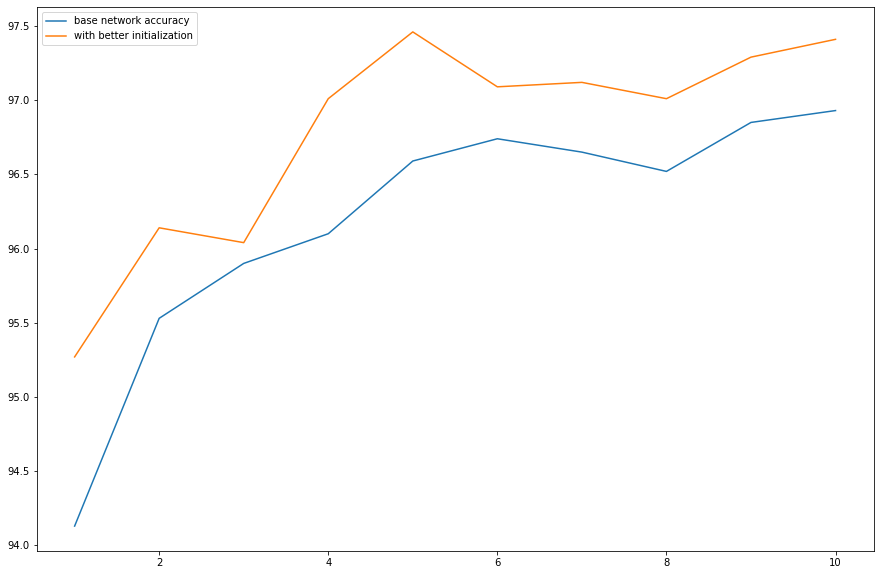

In [ ]:
import matplotlib.pyplot as plt

xs = range(1, 11)
# plt.clf()
# plt.xlim(1, epoch)
plt.plot(xs, base_accuracies, label='base network accuracy')
plt.plot(xs, better_linear_accuracies, label='with better initialization')



plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

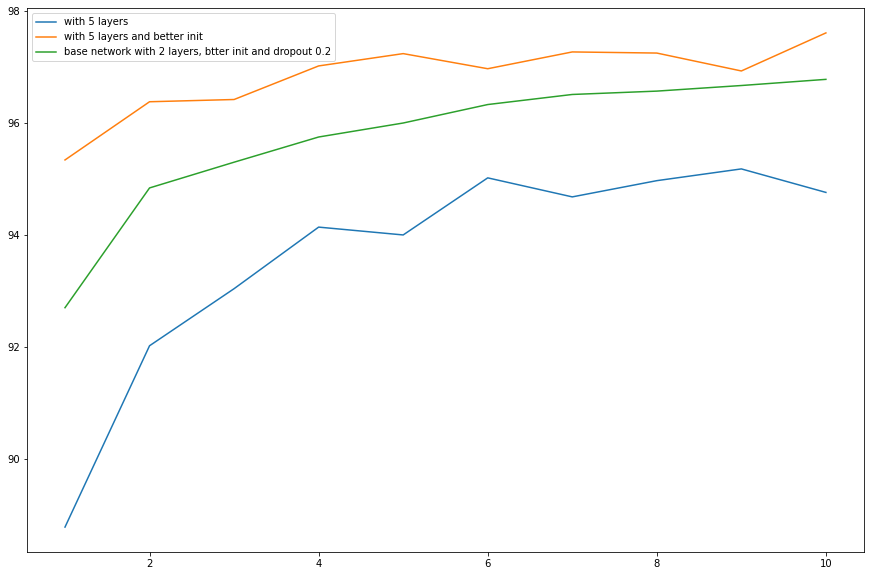

In [ ]:

xs = range(1, 11)
plt.plot(xs, base_many_layers_accuracies, label='with 5 layers')
plt.plot(xs, better_linear_many_layers_acc, label='with 5 layers and better init')
plt.plot(xs, better_linear_dropout2, label='base network with 2 layers, btter init and dropout 0.2')




plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

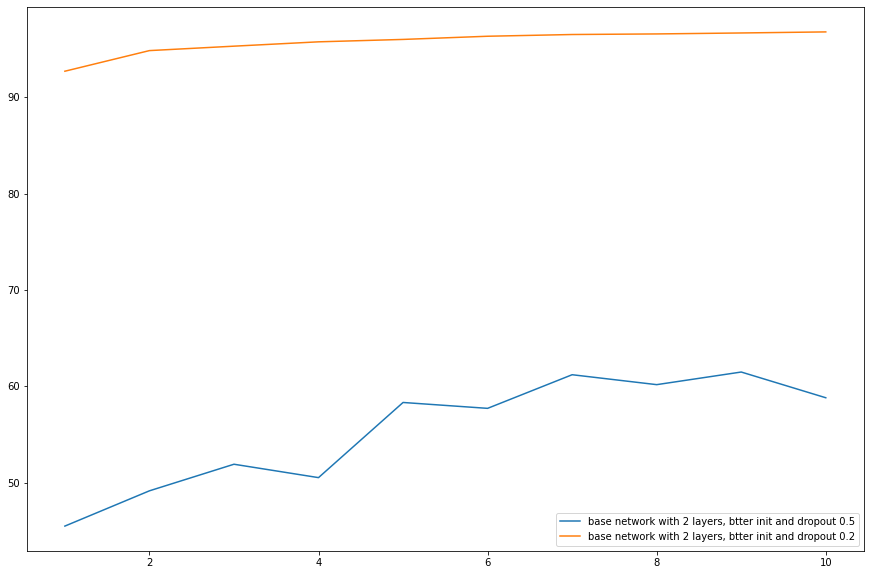

In [ ]:

xs = range(1, 11)
plt.plot(xs, better_linear_dropout, label='base network with 2 layers, btter init and dropout 0.5')
plt.plot(xs, better_linear_dropout2, label='base network with 2 layers, btter init and dropout 0.2')



plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

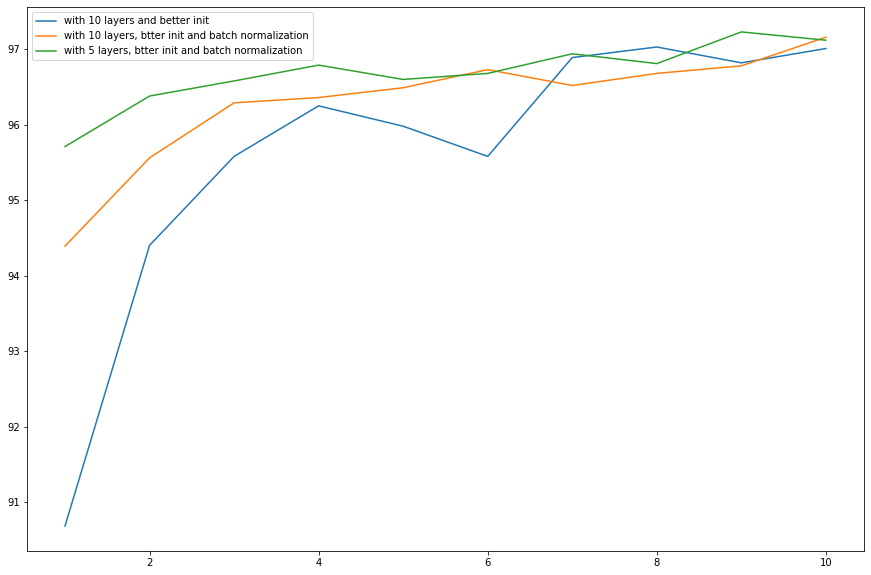

In [ ]:

xs = range(1, 11)
# plt.clf()
# plt.xlim(1, epoch)
plt.plot(xs, better_linear_huge_acc, label='with 10 layers and better init')
plt.plot(xs, better_linear_huge_batch_norm_acc, label='with 10 layers, btter init and batch normalization')
# plt.plot(xs, better_linear_dropout, label='base network with 2 layers, btter init and dropout 0.5')
plt.plot(xs, better_linear_small_batch_norm_acc, label='with 5 layers, btter init and batch normalization')



plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [ ]:

xs = range(1, 11)
# plt.clf()
# plt.xlim(1, epoch)
plt.plot(xs, base_accuracies, label='base network accuracy')
plt.plot(xs, better_linear_accuracies, label='with better initialization')
plt.plot(xs, base_many_layers_accuracies, label='with 5 layers')
plt.plot(xs, better_linear_many_layers_acc, label='with 5 layers and better init')
plt.plot(xs, better_linear_huge_acc, label='with 10 layers and better init')
plt.plot(xs, better_linear_huge_batch_norm_acc, label='with 10 layers, btter init and batch normalization')
# plt.plot(xs, better_linear_dropout, label='base network with 2 layers, btter init and dropout 0.5')
plt.plot(xs, better_linear_small_batch_norm_acc, label='with 5 layers, btter init and batch normalization')



plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_layer = nn.Conv2d(1, 16, 5, padding='same')
        self.pool = nn.MaxPool2d(2)
        self.second_layer = nn.Conv2d(16, 32, 5, padding='same')
        self.fc = nn.Linear(7 * 7 * 32, 10)
    def forward(self, x):
        # 28 x 28
        x = self.pool(F.relu(self.first_layer(x)))
        # 14 x 14
        x = self.pool(F.relu(self.second_layer(x)))
        # 7 x 7
        x = x.view(x.size(0), -1)
        # batchsize x (7 * 7 * 32)
        x = self.fc(x)
        # 10
        return x
    

In [ ]:
torch.manual_seed(42)
trainer = MnistTrainer(batch_size=128)
trainer.train(ConvNet())

[1,   100] loss: 0.657
[1,   200] loss: 0.121
[1,   300] loss: 0.086
[1,   400] loss: 0.071
Accuracy of the network on the 10000 test images: 98.2 %
[2,   100] loss: 0.059
[2,   200] loss: 0.058
[2,   300] loss: 0.052
[2,   400] loss: 0.046
Accuracy of the network on the 10000 test images: 98.87 %
[3,   100] loss: 0.035
[3,   200] loss: 0.035
[3,   300] loss: 0.039
[3,   400] loss: 0.035
Accuracy of the network on the 10000 test images: 98.58 %
[4,   100] loss: 0.028
[4,   200] loss: 0.032
[4,   300] loss: 0.032
[4,   400] loss: 0.029
Accuracy of the network on the 10000 test images: 98.83 %
[5,   100] loss: 0.025
[5,   200] loss: 0.018
[5,   300] loss: 0.027
[5,   400] loss: 0.029
Accuracy of the network on the 10000 test images: 98.91 %
[6,   100] loss: 0.016
[6,   200] loss: 0.020
[6,   300] loss: 0.025
[6,   400] loss: 0.020
Accuracy of the network on the 10000 test images: 99.0 %
[7,   100] loss: 0.014
[7,   200] loss: 0.017
[7,   300] loss: 0.022
[7,   400] loss: 0.021
Accuracy o

KeyboardInterrupt: ignored